In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
import sklearn.metrics as skm
from skimage import io
from skimage.color import rgb2gray,rgba2rgb

%matplotlib inline

DATA_ROOT = Path("D:\\rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("D:\\rfcx-species-audio-detection\\train")
TEST_AUDIO_ROOT = Path("D:\\rfcx-species-audio-detection\\test")

df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

df_tp=pd.read_csv(DATA_ROOT.joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(DATA_ROOT.joinpath('train_fp.csv')).set_index('recording_id')

df_tp.head()

,species_id,songtype_id,t_min,f_min,t_max,f_max
recording_id,,,,,,
003bec244,14,1,44.5440,2531.250,45.1307,5531.25
006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
009b760e6,10,1,50.0854,947.461,52.5293,10852.70


# Audio recording stats:


Text(0.5, 1.0, 'Max frequency observed: 13687.5Hz')

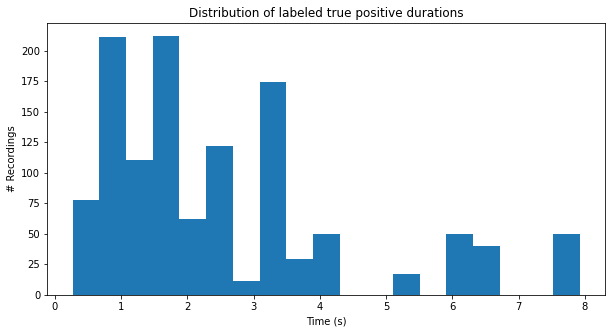

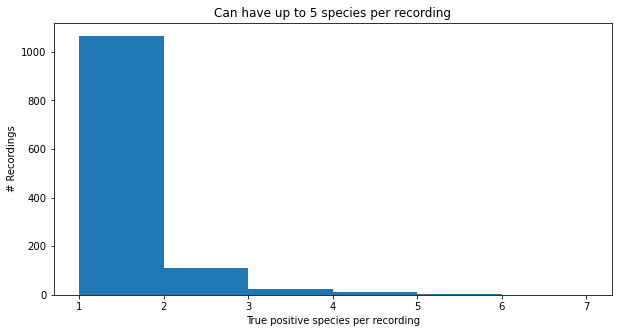

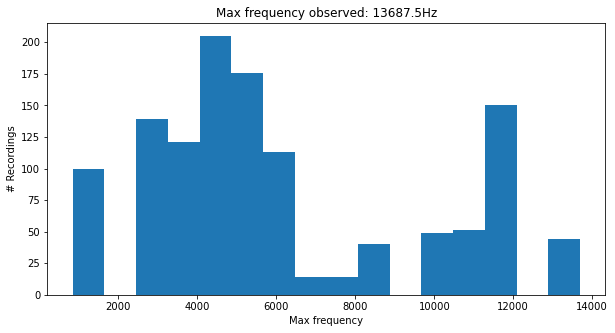

In [15]:
#True positive data:
durs=df_tp['t_max']-df_tp['t_min']
fig, ax = plt.subplots(figsize=(10, 5))
y,x,b=plt.hist(durs, bins='auto')
ax.set_ylabel('# Recordings')
ax.set_xlabel('Time (s)')
ax.set_title('Distribution of labeled true positive durations')

#Number of TP per recording
nspec=[]
for rec in df_tp.index:
    value=df_tp['species_id'][rec]
    if isinstance(value,np.int64):
        n=1
    else:
        n=len(value)
    nspec.append(n)
fig, ax = plt.subplots(figsize=(10, 5))
y,x,b=plt.hist(nspec, bins=range(1,8,1))
ax.set_ylabel('# Recordings')
ax.set_xlabel('True positive species per recording')
ax.set_title('Can have up to %d species per recording' % np.max(nspec))

#Distribution of max frequencies:
fig, ax = plt.subplots(figsize=(10, 5))
y,x,b=plt.hist(df_tp['f_max'],bins='auto')
ax.set_ylabel('# Recordings')
ax.set_xlabel('Max frequency')
ax.set_title('Max frequency observed: %5.1fHz' % np.max(df_tp['f_max']))

In [2]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    
def load_audio(record, sr=48000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac"),
        sr=sr, 
    )
    return y

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, hop_length=params.hop_length,n_fft=params.n_fft
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec
def subtract_median(med,melspec):
    med_sub=np.zeros(melspec.shape)
    for i,col in enumerate(melspec.transpose()):
        med_sub[:,i]=col-med 
    return med_sub

def make_box(df_tp,recording):
    t_start=df_tp['t_min'][recording]
    t_stop= df_tp['t_max'][recording]
    f_min= df_tp['f_min'][recording]
    f_max= df_tp['f_max'][recording]
    #matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    width=t_stop-t_start
    height=f_max-f_min
    xy=(t_start,f_min)
    return t_start, t_stop, f_min, f_max

# EXAMPLE SPECTROGRAM

In [3]:
## TONE TEST:
import numpy as np

sampleRate = 48000
frequency = 500
length = 5

t = np.linspace(0, length, sampleRate * length)  #  Produces a 5 second Audio-File
y = np.sin(frequency * 2 * np.pi * t)  #  Has frequency of 440Hz

wavfile.write(DATA_ROOT.joinpath('sine_%dhz.wav' % frequency), sampleRate, y)

Duration: 5s, fs: 48000


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


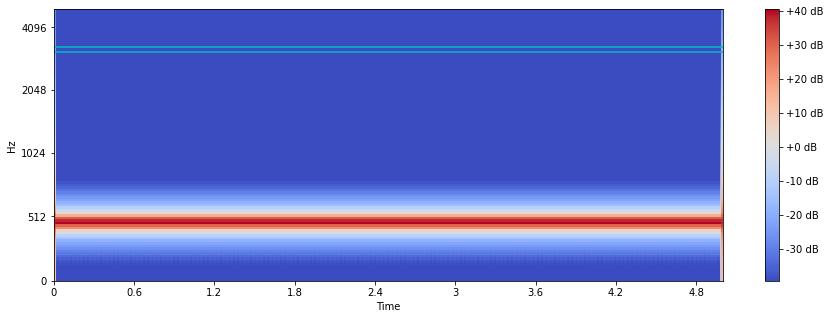

In [15]:
#Plot known spectrum: 5s 500Hz sine wave:
fn='sine_500hz.wav'
pnfn=DATA_ROOT.joinpath(fn)
_,fs=sf.read(pnfn)

params.sr=fs
params.fmax=5000
y, _ = lb.load(pnfn, sr=fs)
print('Duration: %ds, fs: %d' % (y.shape[0]/fs, fs))
params.hop_length=512
params.nmels=128
params.fmin = 20
params.fmax = 5000  
params.n_fft=2048
melspec = compute_melspec(y, params)

fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(
    melspec, 
    sr=params.sr,
    x_axis='time', 
    y_axis='mel',
    hop_length=params.hop_length,
    fmax=params.fmax,
    ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

fm=3100
fx=3300
x=[0,10]
yy=[fm, fm]
ax.plot(x,yy,'c')

x=[0,10]
yy=[fx,fx]
ax.plot(x,yy,'c')

plt.show()


In [103]:
type(singer)

numpy.int64

60.0
(4, 48000, 1.856)
45.04594039916992
1.9093 3.7653 2343.75 4218.75


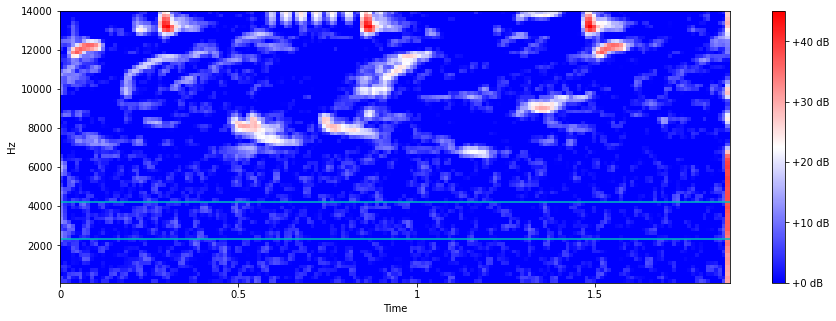

In [3]:
fn=df_tp.index[157]

pnfn=TRAIN_AUDIO_ROOT.joinpath('0_raw').joinpath(fn).with_suffix(".flac")
_,fs=sf.read(pnfn)
singer=df_tp['species_id'][fn]
params.sr=fs

y = load_audio(fn, params.sr, TRAIN_AUDIO_ROOT.joinpath('0_raw'))

print(y.shape[0]/fs)
if isinstance(singer,np.int64):
    y=y[round(df_tp['t_min'][fn]*fs) : round(df_tp['t_max'][fn]*fs)]
else:
    y=y[round(df_tp['t_min'][fn][0]*fs) : round(df_tp['t_max'][fn][0]*fs)]
print((singer,fs,y.shape[0]/fs))
melspec = compute_melspec(y, params)
keep=melspec
med=np.median(melspec,axis=1)
melspec=subtract_median(med,melspec)
min_med=0
max_med=np.max(melspec)
mm=-1*med
mm[mm<0]=0
mm=mm-np.min(mm)
mm=mm/np.max(mm)
mm=mm*np.max(melspec)

melspec=np.column_stack((melspec,mm))
melspec[melspec < 0]=0
# melspec=np.log10(melspec)
# melspec[melspec < 0]=0
m=np.max(melspec)
print(m)
#Make bounding box of audio of interest:

fig, ax = plt.subplots(figsize=(15, 5))

img = librosa.display.specshow(
    melspec,
    sr=params.sr,
    x_axis='time', 
    y_axis='linear', 
    cmap='bwr',
    hop_length=params.hop_length,
    ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

s,st,fm,fx = make_box(df_tp,fn)
ax.set_ylim((params.fmin,params.fmax))
x=[0,10]
yy=[fm, fm]
ax.plot(x,yy,'c')

x=[0,10]
yy=[fx,fx]
ax.plot(x,yy,'c')

#plt.show()

print(s,st,fm,fx)

1.856

In [4]:
y = load_audio(fn, params.sr, TRAIN_AUDIO_ROOT.joinpath('0_raw'))
S_full, phase = lb.magphase(librosa.stft(y))

# Try librosa segmentation example:
S_filter = lb.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(lb.time_to_frames(2, sr=params.sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)


In [16]:
[i for i in range(0,3,1)]

[0, 1, 2]

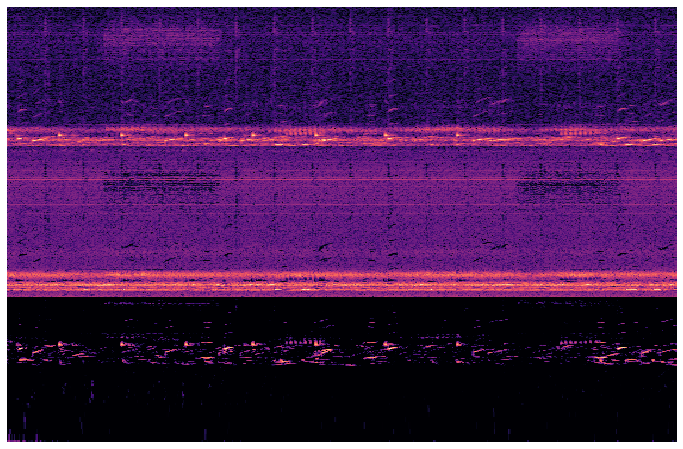

In [22]:

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

# sphinx_gallery_thumbnail_number = 2
sr=params.sr
idx = slice(*lb.time_to_frames([0, 6], sr=params.sr))
plt.figure(figsize=(12, 8))
params.ax=[]
for i in range(0,3,1):
    ax=plt.subplot(3,1,i+1)
    params.ax.append(ax)
    ax.axis('off') 
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(wspace=0, hspace=0)

librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='linear', sr=sr,ax=params.ax[0])

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='linear', sr=sr,ax=params.ax[1])

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=params.ax[2])


# plt.show()

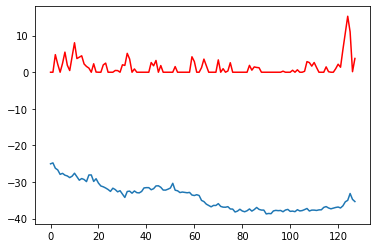

In [59]:
plt.plot(med)
plt.plot(melspec[:,35],'r')

(39.9615, 46.0452)

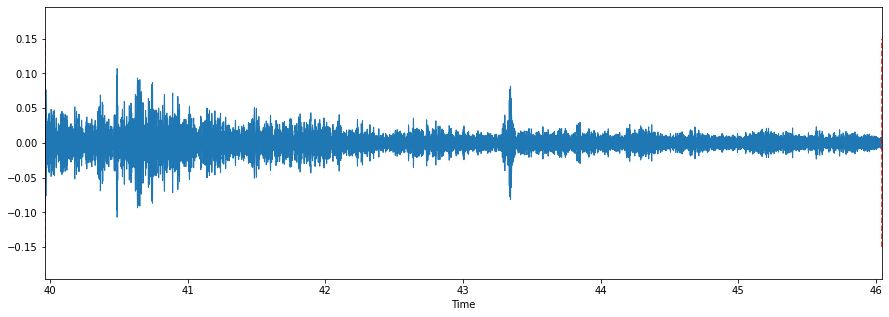

In [19]:
fn=df_tp.index[1]
pnfn=TRAIN_AUDIO_ROOT.joinpath(fn).with_suffix(".flac")
_,fs=sf.read(pnfn)
y = load_audio(fn, fs, TRAIN_AUDIO_ROOT)

fig, ax = plt.subplots(figsize=(15, 5))
librosa.display.waveplot(y, sr=fs)

s,st,fm,fx = make_box(df_tp,fn)
x=[s,s]
yy=[-0.15, 0.15]
plt.plot(x,yy,'--r')

x=[st,st]
plt.plot(x,yy,'--r')
ax.set_xlim([s,st])

In [110]:
ipd.Audio(np.array(y),rate=fs) # load a local WAV file

In [12]:
def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep




def save_spectrum_image(y,params):
    fs=params.sr
    ax=params.ax
    use_root=params.use_root
    melspec = compute_melspec(y, params) #Calculate full spectrogram
    med=np.median(melspec,axis=1) #Take median of full spectrogram
    if params.clip_method == 6: #Particularly for TEST set --> make into smaller clips
        
        #Make a folder for each recording:
        dest=params.use_root.joinpath(params.fn)
        if dest.exists()==False:
            os.mkdir(dest)
            
        # Make 10 6s clips:
        for c,i in enumerate(range(0,60,6)):
            t_min=i
            t_max=i+6
            y_short=y[round(t_min*fs) : round(t_max*fs -1)]
            melspec=compute_melspec(y_short,params)
            params.melspec=subtract_median(med,melspec)
            img_fn='%s_%d.png' % (params.fn,c)
            params.img_pnfn=dest.joinpath(img_fn)
            plot_and_save(params)
    else:
        if params.mode == 'TRAIN':                      
            if params.clip==True: 
                t_min=params.t_min
                t_max=params.t_max
                y=y[round(t_min*fs) : round(t_max*fs)] #Clip suggested time range
                melspec = compute_melspec(y, params) 
                img_fn='%s_%d_%s.png' % (params.type,params.spec,params.fn)
            else:
                img_fn='%s_%d_%s_full.png' % (params.type,params.spec,params.fn)
        else:
            img_fn='%s.png' % (params.fn)
        params.melspec= subtract_median(med,melspec) #Now subtract full spec median from clip or full spec
        params.img_pnfn=params.use_root.joinpath(img_fn)
        plot_and_save(params)

def plot_and_save(params):
        melspec=params.melspec
        img = librosa.display.specshow(
            melspec, 
            sr=params.sr,
            x_axis='time', 
            y_axis='linear', 
            hop_length=params.hop_length,
            cmap='bwr',
            ax=ax)
        #ax.set_ylim((params.fmin,params.fmin))
        ax.axis('off') 
        img_pnfn=params.img_pnfn
        print('\tSaving to %s' % img_pnfn)
        plt.savefig(img_pnfn)
        plt.cla()


0 of 1992
	Loading D:\rfcx-species-audio-detection\test\000316da7.flac
	 Melspec...


NameError: name 'save_spectrum_image' is not defined

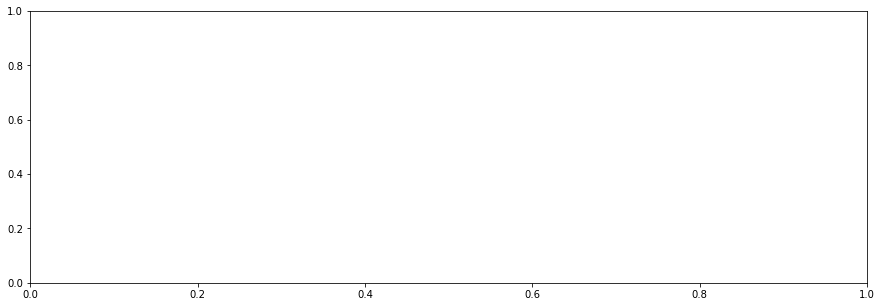

In [3]:
# Make spectrum for each species in recording in train/test:
fig, ax = plt.subplots(figsize=(15, 5))
params.ax=ax
modes = ['TEST']
params.clip_method=6
for mode in modes:
    if mode == 'TEST':
        use_df=df_test
        use_root=TEST_AUDIO_ROOT
        params.clip=False 
    else:
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.clip=False #True = clip to identified length, False = use full
    params.use_root=use_root
    for ii,fn in enumerate(use_df['recording_id']):
        pnfn=use_root.joinpath(fn).with_suffix(".flac")
        _,fs=sf.read(pnfn)
        params.sr=fs
        params.mode=mode

        print('\n%d of %d' % (ii, len(use_df['recording_id'])))
        print('\tLoading %s' % pnfn)
        y = load_audio(fn, params.sr, use_root)

        print('\t Melspec...')
        params.fn=fn
        if mode == 'TRAIN':
            has_tp, has_fp = has_tp_fp(fn,df_tp,df_fp)
            if has_tp:
                info= clip_info(fn,df_tp)
                for i,spec in enumerate(info['species_id']):
                    params.type='TP'
                    params.spec=spec
                    params.t_min=info['t_min'][i]
                    params.t_max=info['t_max'][i]
                    save_spectrum_image(y,params)

            if has_fp:
                info= clip_info(fn,df_fp)
                for i,spec in enumerate(info['species_id']):
                    params.type='FP'
                    params.spec=spec
                    params.t_min=info['t_min'][i]
                    params.t_max=info['t_max'][i]
                    save_spectrum_image(y,params)

        else:
            save_spectrum_image(y,params)


            
    

In [85]:
%debug

> c:\users\brian\anaconda3\envs\fastai2\lib\site-packages\numpy\lib\arraypad.py(819)pad()
    817                 raise ValueError(
    818                     "can't extend empty axis {} using modes other than "
--> 819                     "'constant' or 'empty'".format(axis)
    820                 )
    821         # passed, don't need to do anything more as _pad_simple already

ipdb> quit


In [82]:
# If full TP has only one species, copy that into TP also.
use_df=df_train
use_root=TRAIN_AUDIO_ROOT
for ii,fn in enumerate(use_df['recording_id']):
    has_tp, has_fp = has_tp_fp(fn,df_tp,df_fp)
    if has_tp:
        info= clip_info(fn,df_tp)
        if len(info['species_id']) == 1:
            img_fn='%s_%d_%s_full.png' % ('TP',info['species_id'][0],fn)
            shutil.copy(use_root.joinpath(img_fn), use_root.joinpath('tp_clips'))
            print('from %s to %s' % (use_root.joinpath(img_fn), use_root.joinpath('tp_clips')))
    

from D:\rfcx-species-audio-detection\train\TP_14_003bec244_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_006ab765f_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_007f87ba2_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_17_0099c367b_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_10_009b760e6_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_8_00b404881_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_0_00d442df7_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_18_011f25080_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_15_015113cad

from D:\rfcx-species-audio-detection\train\TP_22_1bc8c196e_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_10_1bd29a4bb_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_6_1c46aa776_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_1ca8c8af6_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_6_1d6371ff5_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_21_1d76cb226_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_15_1d949c49d_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_1e05620be_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_6_1e0e340e1_

from D:\rfcx-species-audio-detection\train\TP_21_352bc8d36_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_35675af70_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_18_356b93991_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_6_35844fa7f_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_22_35a7c2277_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_13_35b60a4a0_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_5_35f9c5c38_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_15_3647cd276_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_16_364e9b5e7

from D:\rfcx-species-audio-detection\train\TP_19_50b93a173_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_0_50f616a04_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_0_512c1ac7e_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_10_51319c540_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_515861db9_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_7_51cb253b0_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_51f69a454_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_3_5280a7fe9_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_16_5281fc845_f

from D:\rfcx-species-audio-detection\train\TP_23_6a0ac2d09_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_4_6a2b677ce_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_2_6a6af3c63_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_0_6b0891684_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_13_6b1093628_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_7_6b891f8f2_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_21_6b9e3f7c6_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_6c032e356_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_19_6c246167d_f

from D:\rfcx-species-audio-detection\train\TP_7_838227e71_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_6_84aed0cf9_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_9_84d2746ce_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_84fd342f8_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_18_851c98ea8_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_7_8531f27ff_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_14_8574d9e81_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_14_8593f9606_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_7_85b891a48_fu

from D:\rfcx-species-audio-detection\train\TP_21_a1ef2a84f_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_22_a2045d15d_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_13_a212bf2e0_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_4_a277651b1_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_19_a2a211fa8_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_a2b073406_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_5_a3194950c_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_10_a38cadf2c_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_16_a3d1e4f37

from D:\rfcx-species-audio-detection\train\TP_17_bda762977_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_20_bdacd5cd2_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_13_bdc8dd456_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_17_bdd4aa62c_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_5_be0356cf5_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_3_be6a8ad0d_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_8_bea3bcffa_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_8_bf58cd236_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_3_bf6aa9579_fu

from D:\rfcx-species-audio-detection\train\TP_3_d82a81c98_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_15_d82d5792e_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_1_d86155abb_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_d8b7f9ed6_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_23_d91f25ca7_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_d922d82e9_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_18_d93aaa1bc_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_13_d96242159_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_1_d9a1b1ea9_

from D:\rfcx-species-audio-detection\train\TP_11_efb6a2e01_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_14_efbfe6b39_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_8_f152e26e3_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_22_f1aa1c855_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_12_f1cc7d0a4_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_8_f2493eda1_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_11_f2890653e_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_4_f2c52223a_full.png to D:\rfcx-species-audio-detection\train\tp_clips
from D:\rfcx-species-audio-detection\train\TP_4_f2d7b8ed8_f

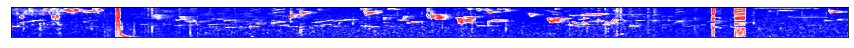

In [117]:
# Combined many FP clips and 1 TP clip into new long clips:

#Generate MANY new long clips--for each TP, select 9 random FP and randomly concatenate together (approximating 60s clip)
dest=TRAIN_AUDIO_ROOT.joinpath('gen_full_tpfp')
if dest.exists()==False:
    os.mkdir(dest)
    #D:\rfcx-species-audio-detection\train\fp_clips\FP_8_00204008d.png
fp=[png for png in TRAIN_AUDIO_ROOT.joinpath('fp_clips').glob('*.png')]
for i,p in enumerate(fp[0:9]):
    im=rgb2gray(io.imread(p)[:,:,0:3])
    if i==0:
        a=im
    else:
        a=np.concatenate((a,im),axis=1)
    
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(a,cmap='bwr')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(DATA_ROOT.joinpath('long_test.png'),dpi=250,pad_inches=0,bbox_inches='tight', transparent=True)